In [2]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from shutil import copyfile

In [3]:
print(tf.__file__)

C:\Users\hp\anaconda3\envs\kush\lib\site-packages\tensorflow\__init__.py


In [4]:
root_path = 'C:/Users/hp/DATA SCIENCE/Practise Projects/CIFAR Dataset Kaggle/cifar-10'

In [5]:
print(os.path.join(root_path,'train'))

C:/Users/hp/DATA SCIENCE/Practise Projects/CIFAR Dataset Kaggle/cifar-10\train


In [6]:
Image_list = os.listdir(os.path.join(root_path,'train'))
Base_Images = os.path.join(root_path,'train')

In [7]:
len(Image_list)
# 50000

50000

In [9]:
os.makedirs(os.path.join(root_path,'Class_wise_Images'))

In [8]:
Training_dir = os.path.join(root_path,'Class_wise_Images/training')
Validation_dir = os.path.join(root_path,'Class_wise_Images/validation')

In [11]:
#makedirs always takes just 1 input
os.makedirs(os.path.join(root_path,'Class_wise_Images/training'))
os.makedirs(os.path.join(root_path,'Class_wise_Images/validation'))

In [9]:
#reading the training labels
training_labels = pd.read_csv("C:/Users/hp/DATA SCIENCE/Practise Projects/CIFAR Dataset Kaggle/cifar-10/trainLabels.csv")

In [10]:
training_labels.head(2)

,id,label
0,1,frog
1,2,truck


In [15]:
#We have 10 classes so will have to create 10 folders for each class in each training folder and validation folder 

In [11]:
Classes = list(training_labels["label"].unique())

In [20]:
#the below code creates 10 folders in validation directory and 10 folders in training directory
for i in Classes:
    os.makedirs(os.path.join(Validation_dir,i))
    os.makedirs(os.path.join(Training_dir,i))

In [21]:
#Stratified Samples (20% are kept for testing the model) there are 10 classes, each should have similar proportion
stratified_sample = training_labels.groupby('label').apply(lambda x: x.sample(frac=0.20))

In [22]:
stratified_sample = stratified_sample[["id","label"]]

In [23]:
stratified_sample.head()

id     label
label                          
airplane 33076  33077  airplane
         33235  33236  airplane
         16920  16921  airplane
         220      221  airplane
         8018    8019  airplane

In [24]:
#Dataset copied to respective folders in Validation Dir
for i in Classes:
    list_ids_class_i = list(stratified_sample[stratified_sample["label"]==i]["id"].unique())
    for j in list_ids_class_i:
        if (os.path.getsize(os.path.join(Base_Images,(j.astype(str)+'.png')))) > 0: 
            copyfile(os.path.join(Base_Images,(j.astype(str)+'.png')), os.path.join(os.path.join(Validation_dir,i),(j.astype(str)+'.png')))

In [25]:
#Dataset copied to respective folders in Training Dir
for i in Classes:
    list_ids_class_i = list(set(training_labels[training_labels["label"]==i]["id"].unique()) - set(stratified_sample[stratified_sample["label"]==i]["id"].unique()))
    for j in list_ids_class_i:
        if (os.path.getsize(os.path.join(Base_Images,(j.astype(str)+'.png')))) > 0:
            copyfile(os.path.join(Base_Images,(j.astype(str)+'.png')), os.path.join(os.path.join(Training_dir,i),(j.astype(str)+'.png')))

In [7]:
#checking the shape of image
from skimage import io
# Load the image
image = io.imread(r"C:\Users\hp\DATA SCIENCE\Practise Projects\CIFAR Dataset Kaggle\cifar-10\Class_wise_Images\training\airplane\30.png")

In [8]:
image.shape

(32, 32, 3)

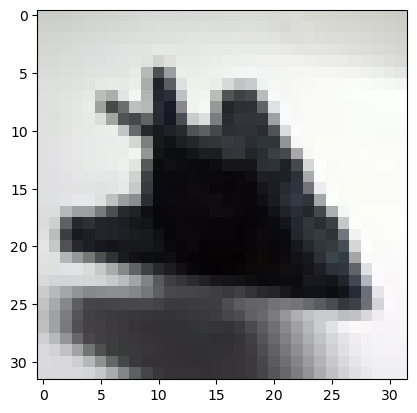

In [11]:
plt.imshow(image)

In [17]:
#steps
#1 use image generator because it automatically resizes the images if they are of different shape / sizes

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=0.4) #except for rescale other parameters lead to data augmentation
Validation_datagen = ImageDataGenerator(rescale=1/255)

In [13]:
train_generator = train_datagen.flow_from_directory(Training_dir ,  # This is the source directory for training images
        target_size=(32, 32),  # All images will be resized to 300x300 (vimp in real world scenarios)
        batch_size=50, 
        class_mode='categorical')

Found 40000 images belonging to 10 classes.


In [14]:
Validation_generator = train_datagen.flow_from_directory( Validation_dir,  # This is the source directory for training images
        target_size=(32, 32),  # All images will be resized to 300x300 (vimp in real world scenarios)
        batch_size=50, 
        class_mode='categorical')

Found 10000 images belonging to 10 classes.


In [15]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.90): # Experiment with changing this value
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [16]:
from tensorflow import keras

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation = 'relu'),
    tf.keras.layers.Dense(units=10,activation = 'softmax')])

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.001),loss='sparse_categorical_crossentropy')
callbacks = myCallback()

In [ ]:
history = model.fit(
      train_generator,  
      epochs=800,
    validation_data = Validation_generator,
      verbose=2,callbacks=[callbacks])

In [ ]:
history.to_csv("history.csv")